In [18]:
import xarray as xr
import numpy as np
import sys
import hydra

from typing import Optional
import datetime

ATTRS ={'time': {'dtype': 'int64',}, # 'units': 'days since 2019-01-01', }, 
        'lon': {'dtype': 'float32', 'valid_min': -180., 'valid_max': 180.,
                'long_name': 'longitude', 'standard_name': 'longitude',
                'units': 'degrees_east'},
        'lat': {'dtype': 'float32', 'valid_min': -90., 'valid_max': 90.,
                'long_name': 'latitude', 'standard_name': 'latitude',
                'units': 'degrees_north'},
        'ugos': {'dtype': 'float32', 'valid_min': -100., 'valid_max': 100.,
                'units': 'm/s',
                'long_name': 'Eastward total velocity',
                },
        'vgos': {'dtype': 'float32', 'valid_min': -100., 'valid_max': 100.,
                'units': 'm/s',
                'long_name': 'Northward total velocity',
                },
                }
COMPLEVEL = 4
ZLIB = True
FV32 = 1.e+20
ENC_FV = {'zlib': ZLIB, 'complevel': COMPLEVEL, '_FillValue': FV32,
          'dtype': 'float32'}
ENC = {'zlib': ZLIB, 'complevel': COMPLEVEL, 'dtype': 'float32'}


def save(ds: xr.Dataset, listkey: list, file_out: str, 
         ATTR_VARS: Optional[dict] = ATTRS, fillvalue: Optional[float] = FV32):
    encoding = {}
    for key in listkey:
        print(key)
        dic_attr = {}
        if key in ATTR_VARS.keys():
            dic_attr = ATTR_VARS[key]
        ds[key].values[np.isnan(ds[key].values)] = fillvalue
        ds = ds.assign({key: (['time', 'lat', 'lon'], ds[key].values,
                            dic_attr)})

        encoding[key] = ENC_FV
        print(ENC_FV)
    for key in ('lon', 'lat', 'time'):
    #for key in ('lon', 'lat'):
        dic_attr = {}
        if key in ATTR_VARS.keys():
            dic_attr = ATTR_VARS[key]
        ds = ds.assign({key: ([key,], ds[key].values,
                            dic_attr)})
        encoding[key] = ENC
    encoding['time']['dtype'] = 'int64'
    encoding['lat']['dtype'] = 'float32'
    encoding['lon']['dtype'] = 'float32'
    
    print(encoding)

    t0 = ds['time'].values[0] - np.timedelta64(12, 'h')
    t1 = ds['time'].values[-1] + np.timedelta64(12, 'h')

    ds.attrs['title'] = 'multivar_uv'
    ds.attrs['project'] = 'multivar_uv'
    ds.attrs['summary'] = ''
    ds.attrs['references'] = ''
    ds.attrs['institution'] = 'IMT Atlantic'
    ds.attrs['creator_name'] = 'Theo'
    ds.attrs['version_id'] = '0.1'
    ds.attrs['date_created'] = str(datetime.datetime.now())
    ds.attrs['geospatial_lat_min'] = f'{np.min(ds["lat"].values)}N'
    ds.attrs['geospatial_lat_max'] = f'{np.max(ds["lat"].values)}N'
    ds.attrs['geospatial_lon_min'] = f'{np.min(ds["lon"].values)}E'
    ds.attrs['geospatial_lon_max'] = f'{np.max(ds["lon"].values)}E'
    ds.attrs['time_coverage_start'] = np.datetime_as_string(t0, unit='s')
    ds.attrs['time_coverage_end'] = np.datetime_as_string(t1, unit='s')
    #ds.to_netcdf(file_out, 'w', format="NETCDF4", encoding=encoding)
    return ds,encoding

path_file="/Odyssey/private/t22picar/multivar_uv/rec/multivar_mapping_ssh_duacs_sst_w_to_u_v_L4_10y_11d_0m_norm_dirac"

print(path_file)

tstart_1='2019-01-01'
tend_1= '2019-06-30'

tstart_2='2019-07-01'
tend_2='2019-12-31'

result_filepath = f"{path_file}/2019_global_4/test_data_dim0.nc"
res_uo_1 = xr.open_dataset(result_filepath)
res_uo_1 = res_uo_1.sel(time=slice(tstart_1, tend_1))

result_filepath = f"{path_file}/2019_global_4_2/test_data_dim0.nc"
res_uo_2 = xr.open_dataset(result_filepath)
res_uo_2 = res_uo_2.sel(time=slice(tstart_2, tend_2))

res_uo = xr.concat([res_uo_1, res_uo_2], dim='time')
res_uo = res_uo.rename({'out': 'ugos'})

result_filepath = f"{path_file}/2019_global_4/test_data_dim1.nc"
res_vo_1 = xr.open_dataset(result_filepath)
res_vo_1 = res_vo_1.sel(time=slice(tstart_1, tend_1))

result_filepath = f"{path_file}/2019_global_4_2/test_data_dim1.nc"
res_vo_2 = xr.open_dataset(result_filepath)
res_vo_2 = res_vo_2.sel(time=slice(tstart_2, tend_2))

res_vo = xr.concat([res_vo_1, res_vo_2], dim='time')
res_vo = res_vo.rename({'out': 'vgos'})
ds_maps = xr.merge([res_uo, res_vo])
#ds_maps.to_netcdf(f"rec/{path_file}/test_data.nc")


/Odyssey/private/t22picar/multivar_uv/rec/multivar_mapping_ssh_duacs_sst_w_to_u_v_L4_10y_11d_0m_norm_dirac


In [19]:
###
### ADD MASK + NETCDF CONFIG
###

### FILTER ####
mask = np.load('/Odyssey/private/t22picar/2023a_SSH_mapping_OSE/nb_diags_THEO/uv_score_mask/mask_glorys_4th.npy')
mask = mask[np.newaxis,:,:]
mask = mask.repeat(365,axis=0)
ds_maps = ds_maps.where(mask, np.nan)

In [20]:
# Récupérer la liste des variables sans les dimensions
variables = [var for var in ds_maps.variables if var not in ds_maps.dims]
folder_out = path_file
ds_maps,encoding = save(ds_maps,variables,folder_out)

ugos
{'zlib': True, 'complevel': 4, '_FillValue': 1e+20, 'dtype': 'float32'}
vgos
{'zlib': True, 'complevel': 4, '_FillValue': 1e+20, 'dtype': 'float32'}
{'ugos': {'zlib': True, 'complevel': 4, '_FillValue': 1e+20, 'dtype': 'float32'}, 'vgos': {'zlib': True, 'complevel': 4, '_FillValue': 1e+20, 'dtype': 'float32'}, 'lon': {'zlib': True, 'complevel': 4, 'dtype': 'float32'}, 'lat': {'zlib': True, 'complevel': 4, 'dtype': 'float32'}, 'time': {'zlib': True, 'complevel': 4, 'dtype': 'float32'}}


In [24]:
#Select day per day 
from datetime import datetime, timedelta
# Définir la date de début et la date de fin
start_date = datetime(2019, 1, 1)
end_date = datetime(2019, 1, 3)

In [25]:
import os

# Chemin du dossier que vous souhaitez créer
dossier_path = path_file+'/daily'
# Créer le dossier
os.makedirs(dossier_path, exist_ok=True)

In [27]:

# Boucle sur chaque jour de la période
current_date = start_date
while current_date < end_date:
    #print(current_date.strftime('%Y-%m-%d'))  # Affiche la date au format AAAA-MM-JJ
    ds_map_day=ds_maps.sel(time=current_date)
    folder_out = path_file+f"/daily/unet_rec_{current_date.strftime('%Y-%m-%d')}.nc"
    ds_map_day.to_netcdf(folder_out, 'w', format="NETCDF4", encoding=encoding)
    current_date += timedelta(days=1)  # Passe au jour suivant


In [ ]:


import os 
import shutil
# Vérifie si le fichier test_data.nc existe dans le dossier courant
if os.path.isfile(f"rec/{path_file}/test_data.nc"):
    # Vérifie si le dossier 2019_global_4 existe et le supprime
    if os.path.isdir(f"rec/{path_file}/2019_global_4"):
        shutil.rmtree(f"rec/{path_file}/2019_global_4")
        print("Le dossier 2019_global_4 a été supprimé.")
    else:
        print("Le dossier 2019_global_4 n'existe pas.")

    # Vérifie si le dossier 2019_global_4_2 existe et le supprime
    if os.path.isdir(f"rec/{path_file}/2019_global_4_2"):
        shutil.rmtree(f"rec/{path_file}/2019_global_4_2")
        print("Le dossier 2019_global_4_2 a été supprimé.")
    else:
        print("Le dossier 2019_global_4_2 n'existe pas.")
else:
    print("Le fichier test_data.nc n'existe pas.")


In [40]:
import xarray
from typing import Optional
import datetime
import numpy

ATTRS ={'time': {'dtype': 'int64',}, # 'units': 'days since 2019-01-01', }, 
        'lon': {'dtype': 'float32', 'valid_min': -180., 'valid_max': 180.,
                'long_name': 'longitude', 'standard_name': 'longitude',
                'units': 'degrees_east'},
        'lat': {'dtype': 'float32', 'valid_min': -90., 'valid_max': 90.,
                'long_name': 'latitude', 'standard_name': 'latitude',
                'units': 'degrees_north'},
        'ugos': {'dtype': 'float32', 'valid_min': -100., 'valid_max': 100.,
                'units': 'm/s',
                'long_name': 'Eastward total velocity',
                },
        'vgos': {'dtype': 'float32', 'valid_min': -100., 'valid_max': 100.,
                'units': 'm/s',
                'long_name': 'Northward total velocity',
                },
                }

COMPLEVEL = 4
ZLIB = True
FV32 = 1.e+20
ENC_FV = {'zlib': ZLIB, 'complevel': COMPLEVEL, '_FillValue': FV32,
          'dtype': 'float32'}
ENC = {'zlib': ZLIB, 'complevel': COMPLEVEL, 'dtype': 'float32'}


def save(ds: xarray.Dataset, listkey: list, file_out: str, 
         ATTR_VARS: Optional[dict] = ATTRS, fillvalue: Optional[float] = FV32):
    encoding = {}
    for key in listkey:
        print(key)
        dic_attr = {}
        if key in ATTR_VARS.keys():
            dic_attr = ATTR_VARS[key]
        ds[key].values[numpy.isnan(ds[key].values)] = fillvalue
        ds = ds.assign({key: (['time', 'lat', 'lon'], ds[key].values,
                            dic_attr)})

        encoding[key] = ENC_FV
        print(ENC_FV)
    for key in ('lon', 'lat', 'time'):
    #for key in ('lon', 'lat'):
        dic_attr = {}
        if key in ATTR_VARS.keys():
            dic_attr = ATTR_VARS[key]
        ds = ds.assign({key: ([key,], ds[key].values,
                            dic_attr)})
        encoding[key] = ENC
    encoding['time']['dtype'] = 'int64'
    encoding['lat']['dtype'] = 'float32'
    encoding['lon']['dtype'] = 'float32'
    
    print(encoding)

    t0 = ds['time'].values[0] - numpy.timedelta64(12, 'h')
    t1 = ds['time'].values[-1] + numpy.timedelta64(12, 'h')

    ds.attrs['title'] = 'multivar_uv'
    ds.attrs['project'] = 'multivar_uv'
    ds.attrs['summary'] = ''
    ds.attrs['references'] = ''
    ds.attrs['institution'] = 'IMT Atlantic'
    ds.attrs['creator_name'] = 'Theo'
    ds.attrs['version_id'] = '0.1'
    ds.attrs['date_created'] = str(datetime.datetime.now())
    ds.attrs['geospatial_lat_min'] = f'{numpy.min(ds["lat"].values)}N'
    ds.attrs['geospatial_lat_max'] = f'{numpy.max(ds["lat"].values)}N'
    ds.attrs['geospatial_lon_min'] = f'{numpy.min(ds["lon"].values)}E'
    ds.attrs['geospatial_lon_max'] = f'{numpy.max(ds["lon"].values)}E'
    ds.attrs['time_coverage_start'] = numpy.datetime_as_string(t0, unit='s')
    ds.attrs['time_coverage_end'] = numpy.datetime_as_string(t1, unit='s')
    ds.to_netcdf(file_out, 'w', format="NETCDF4", encoding=encoding)
    #return ds


In [46]:
import xarray as xr
folder_data = "/Odyssey/private/t22picar/multivar_uv/rec/multivar_mapping_ssh_neurost_sst_w_to_u_v_L4_10y_11d_0m_norm/"
#folder_data = "/Odyssey/private/t22picar/multivar_uv/rec/multivar_mapping_ssh_duacs_sst_w_to_u_v_L4_10y_11d_0m_norm/"
#folder_data = "/Odyssey/private/t22picar/multivar_uv/rec/multivar_mapping_ssh_duacs_sst_w_to_u_v_L4_10y_11d_15m_norm/"
ds_map = xr.open_dataset(folder_data+"test_data.nc")

In [47]:
### FILTER ####
mask = numpy.load('/Odyssey/private/t22picar/2023a_SSH_mapping_OSE/nb_diags_THEO/uv_score_mask/mask_glorys_4th.npy')
mask = mask[numpy.newaxis,:,:]
mask = mask.repeat(365,axis=0)
ds_map = ds_map.where(mask, numpy.nan)

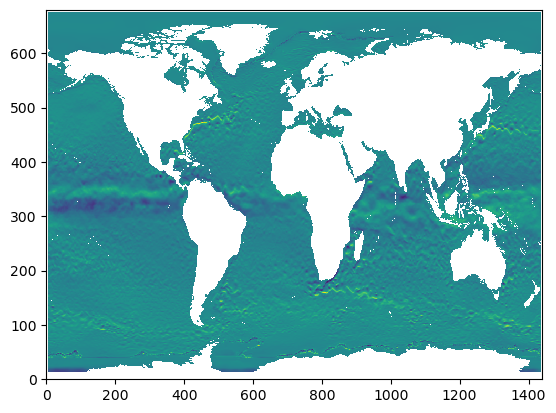

In [48]:
import matplotlib.pyplot as plt
plt.pcolormesh(ds_map.ugos[0])

In [49]:
# Récupérer la liste des variables sans les dimensions
variables = [var for var in ds_map.variables if var not in ds_map.dims]
variables

['ugos', 'vgos']

In [50]:
file_saved = "test_data_filtred.nc"
folder_out = folder_data+file_saved
ds_map = save(ds_map,variables,folder_out)

ugos
{'zlib': True, 'complevel': 4, '_FillValue': 1e+20, 'dtype': 'float32'}
vgos
{'zlib': True, 'complevel': 4, '_FillValue': 1e+20, 'dtype': 'float32'}
{'ugos': {'zlib': True, 'complevel': 4, '_FillValue': 1e+20, 'dtype': 'float32'}, 'vgos': {'zlib': True, 'complevel': 4, '_FillValue': 1e+20, 'dtype': 'float32'}, 'lon': {'zlib': True, 'complevel': 4, 'dtype': 'float32'}, 'lat': {'zlib': True, 'complevel': 4, 'dtype': 'float32'}, 'time': {'zlib': True, 'complevel': 4, 'dtype': 'float32'}}


In [ ]:
ds_map

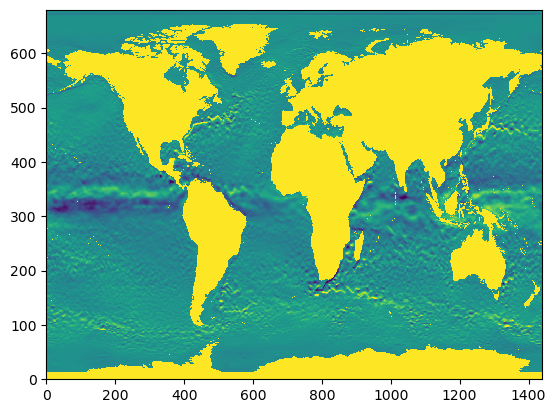

In [63]:
import matplotlib.pyplot as plt
plt.pcolormesh(ds_map.ugos[0],vmin=-1,vmax=1)

In [13]:
import xarray as xr
folder_data = "/Odyssey/private/t22picar/data/rec_old/multivar_mapping_ssh_neurostv2_sst_w_to_u_v_L4_10y_7d/daily/unet_rec_2019-01-01.nc"
ds_map = xr.open_dataset(folder_data)
ds_map

<xarray.Dataset> Size: 8MB
Dimensions:  (lat: 680, lon: 1440)
Coordinates:
  * lon      (lon) float32 6kB -180.0 -179.7 -179.5 -179.2 ... 179.4 179.7 179.9
  * lat      (lat) float32 3kB -80.0 -79.75 -79.5 -79.25 ... 89.5 89.75 90.0
    time     datetime64[ns] 8B ...
Data variables:
    ugos     (lat, lon) float32 4MB ...
    vgos     (lat, lon) float32 4MB ...
Attributes: (12/14)
    title:                multivar_uv
    project:              multivar_uv
    summary:              
    references:           
    institution:          IMT Atlantic
    creator_name:         Theo
    ...                   ...
    geospatial_lat_min:   -80.0N
    geospatial_lat_max:   90.0N
    geospatial_lon_min:   -180.0E
    geospatial_lon_max:   179.9166717529297E
    time_coverage_start:  2018-12-31T12:00:00
    time_coverage_end:    2019-12-31T12:00:00

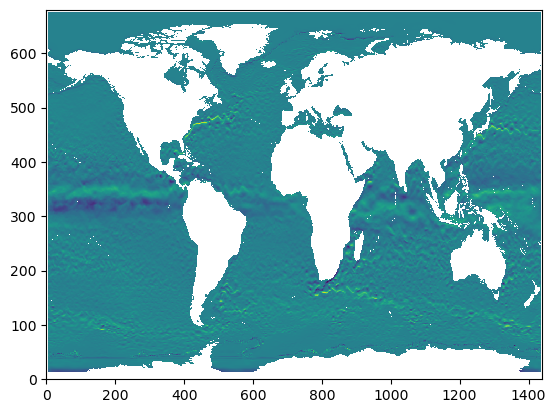

In [17]:
import matplotlib.pyplot as plt
plt.pcolormesh(ds_map.ugos)